In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

sns.set_context("talk")
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from src.load_data import load_data

In [4]:
# load data
epoch_key = ("bon", 8, 4)
data = load_data(epoch_key)

Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


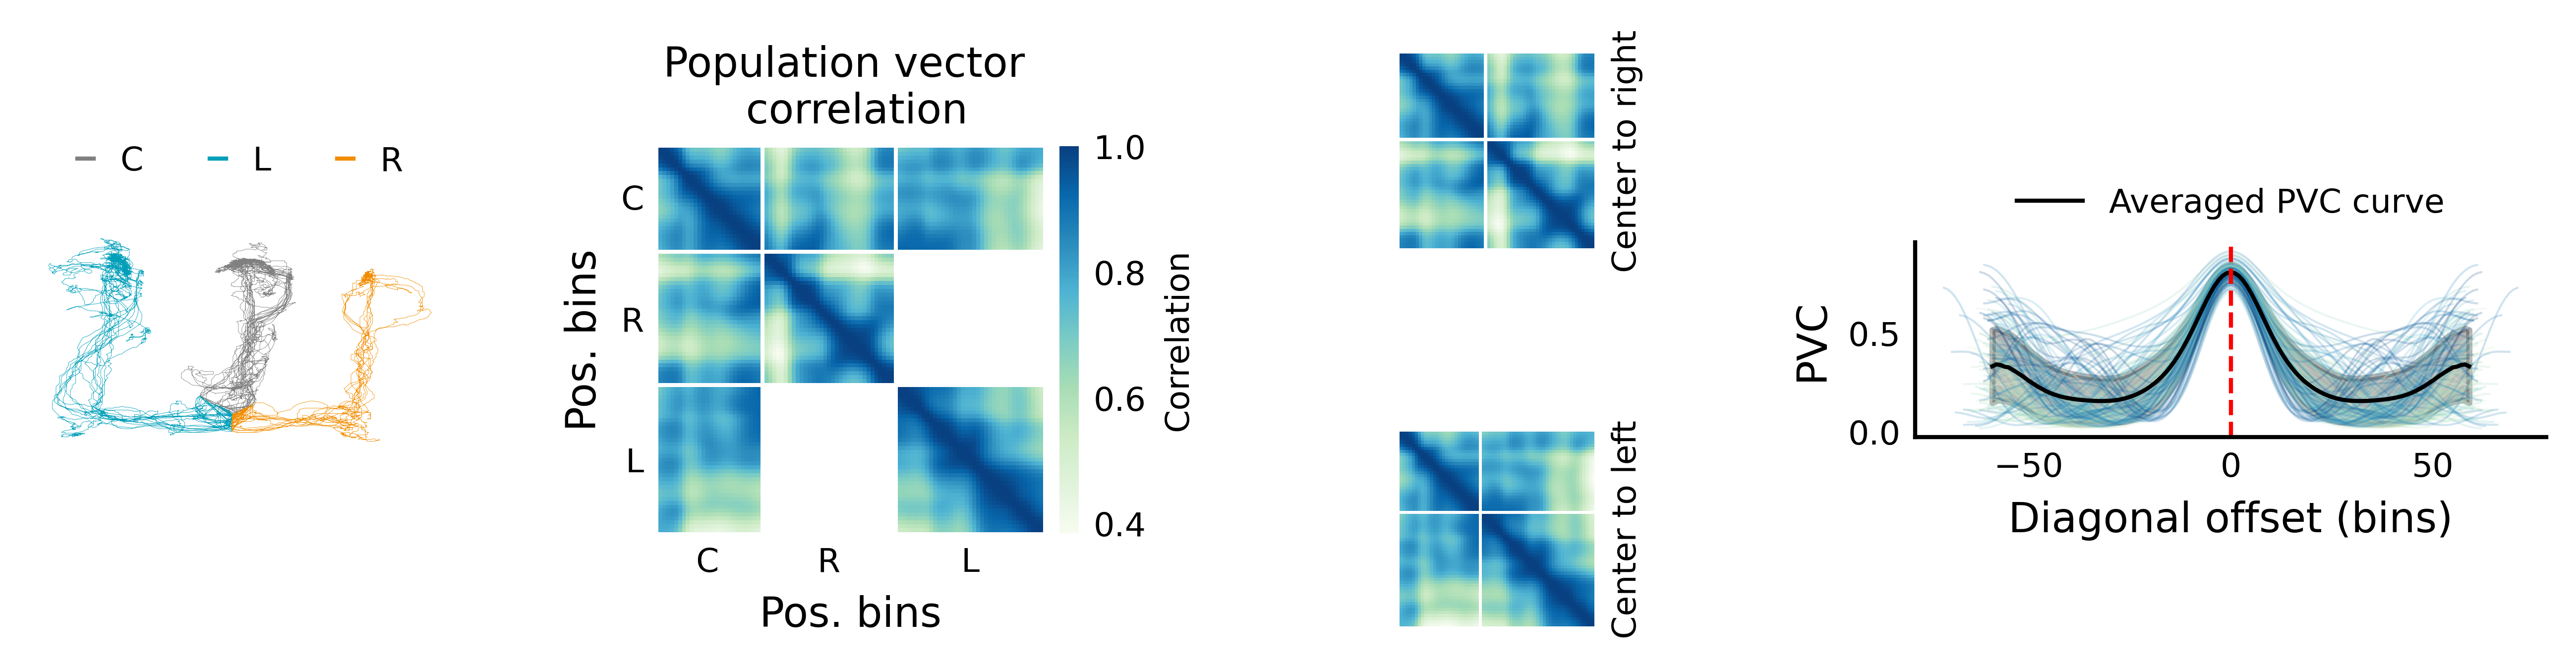

In [59]:
# !!! need to run CorrelationwithPVC.ipynb first to generate the pickle file if not exist
# './sweep_replay_correlation_with_PVC.pickle'
with open("./sweep_replay_correlation_with_PVC.pickle", "rb") as f:
    (
        all_offsets,
        all_mean_diagonal_sums,
        all_corr_matrix,
        all_unique_nan_index,
        animal_names,
        all_corrbin_perday_concat,
        all_sweep_len_perday_concat,
        all_peak_sweep_len_perday_concat,
        all_exponent_perday_concat,
    ) = pickle.load(f)

fig = plt.figure(figsize=(9, 2.5), dpi=300)
gs = gridspec.GridSpec(4, 4, width_ratios=[2, 2, 2, 3])
labelsize = 10
ticksize = 8

# select colors equals to number of animals from a colormap
# put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

# ax0
ax0 = plt.subplot(gs[:, 0])
colors = ["grey", "#009FB9", "#F18D00"]
legends = ["C", "L", "R"]
for i, (task, df) in enumerate(data["position_info"].groupby("arm_name")):
    ax0.plot(
        df.x_position,
        df.y_position,
        color=colors[i],
        linewidth=0.1,
        label=legends[i],
    )


# axis ticks off
ax0.set_xticks([])
ax0.set_yticks([])

# add legend to ax0 make the line shorter and thicker
# display legend in three columns at the top of the ax0
legend = ax0.legend(
    fontsize=ticksize,
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.5, 1.3),
    handlelength=0.5,
    ncol=3,
)
# Get the handles (legend lines) from the legend
handles = legend.legendHandles

# Set the linewidth of the legend lines
for handle in handles:
    handle.set_linewidth(1.0)  # Adjust the linewidth as needed

# change the x and y ratio as 2:1
ax0.set_aspect(0.5, adjustable="box")

# ax1
ax1 = plt.subplot(gs[:, 1])
corr_matrix = all_corr_matrix[("bon", 8, 2)]
unique_nan_index = all_unique_nan_index[("bon", 8, 2)]
# imshow of the correlation matrix
# set raw: unique_nan_index[0]:unique_nan_index[1], column: unique_nan_index[1]:len(corr_matrix) as nan
# set raw: unique_nan_index[1]:len(corr_matrix), column: unique_nan_index[0]:unique_nan_index[1] as nan
corr_matrix[
    unique_nan_index[0] : unique_nan_index[1], unique_nan_index[1] : len(corr_matrix)
] = np.nan
corr_matrix[
    unique_nan_index[1] : len(corr_matrix), unique_nan_index[0] : unique_nan_index[1]
] = np.nan
ax1.imshow(corr_matrix, cmap="GnBu")
ax1.set_xlabel("Pos. bins", fontsize=labelsize)
ax1.set_ylabel("Pos. bins", fontsize=labelsize)
# title
ax1.set_title("Population vector \n correlation", fontsize=labelsize)
# x y ticks
ax1.set_xticks([12, 43, 79])
ax1.set_yticks([12, 43, 79])
# tick labels as 'C', 'R' ,'L'
ax1.set_xticklabels(["C", "R", "L"], fontsize=ticksize)
ax1.set_yticklabels(["C", "R", "L"], fontsize=ticksize)
# ax1.set_title("Population vector \n correlation (PVC)", fontsize=labelsize)
# make the colobar
cbar = plt.colorbar(
    ax1.imshow(corr_matrix, cmap="GnBu"), ax=ax1, fraction=0.046, pad=0.04
)
cbar.set_label("Correlation", fontsize=ticksize)
# set colorbar box off
cbar.outline.set_visible(False)
# set colorbar ticks with fontsize ticksizes
cbar.ax.tick_params(labelsize=ticksize)
# reduce the length of the colorbar

ax2 = plt.subplot(gs[0:2, 2])
rightarm_corr_matrix = corr_matrix[: unique_nan_index[1], : unique_nan_index[1]]
ax2.imshow(rightarm_corr_matrix, cmap="GnBu")
ax2.set_xticks([])
ax2.set_yticks([])
# set y label on the right as 'Center to right arm'
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Center to right", fontsize=ticksize)


ax3 = plt.subplot(gs[2:4, 2])
row_index = np.arange(0, unique_nan_index[0])
row_index = np.append(row_index, np.arange(unique_nan_index[1], len(corr_matrix)))
column_index = row_index
leftarm_corr_matrix = corr_matrix[row_index, :][:, column_index]
ax3.imshow(leftarm_corr_matrix, cmap="GnBu")
ax3.set_xticks([])
ax3.set_yticks([])
# set y label on the right as 'Center to left arm'
ax3.yaxis.set_label_position("right")
ax3.set_ylabel("Center to left", fontsize=ticksize)

# ax4
ax4 = plt.subplot(gs[1:3, 3])
# using cmap to get the color of each line
cmap = plt.get_cmap("GnBu")
# set the color cycle of the plot
plt.gca().set_prop_cycle(
    color=[cmap(i) for i in np.linspace(0, 1, len(all_offsets.keys()))]
)
# plot all mean_diagonal_sums

all_half_sum = []
for key in all_offsets.keys():
    Offsets = all_offsets[key]
    mean_diagonal_sums = all_mean_diagonal_sums[key]
    # normalize mean_diagonal_sums to 0 to 1
    mean_diagonal_sums = (mean_diagonal_sums - np.min(mean_diagonal_sums)) / (
        np.max(mean_diagonal_sums) - np.min(mean_diagonal_sums)
    )
    # Gaussian smooth the mean_diagonal_sums
    mean_diagonal_sums = gaussian_filter1d(mean_diagonal_sums, sigma=5)
    ax4.plot(Offsets, mean_diagonal_sums, alpha=0.2, linewidth=0.5)
    # keep the right half of the mean_diagonal_sums
    half_sum = mean_diagonal_sums[int(len(mean_diagonal_sums) / 2) :]
    all_half_sum.append(half_sum)

# make each elemnt in all_half_sum have the same length, pad np.nan  to the end of the shorter element
all_half_sum = np.array(all_half_sum)
# max_len = np.max([len(x) for x in all_half_sum])
max_len = 60

all_half_sum = np.array(
    [
        np.pad(x, (0, max_len - len(x)), "constant", constant_values=np.nan)
        if len(x) < max_len
        else x[:max_len]
        for x in all_half_sum
    ]
)

# take nanmean of all_half_sum along the first axis
mean_half_sum = np.nanmean(all_half_sum, axis=0)
# plot mean_half_sum
ax4.plot(
    np.arange(0, len(mean_half_sum)),
    mean_half_sum,
    label="Averaged PVC curve",
    linewidth=1,
    color="k",
)
# add shaded area of std to the plot
ax4.fill_between(
    np.arange(0, len(mean_half_sum)),
    mean_half_sum + np.nanstd(all_half_sum, axis=0),
    mean_half_sum - np.nanstd(all_half_sum, axis=0),
    alpha=0.3,
    color="k",
)
# plot by flipping mean_half_sum to the left side
ax4.plot(
    -np.arange(0, len(mean_half_sum)),
    mean_half_sum,
    linewidth=1,
    color="k",
)
# add shaded area of std to the plot
ax4.fill_between(
    -np.arange(0, len(mean_half_sum)),
    mean_half_sum + np.nanstd(all_half_sum, axis=0),
    mean_half_sum - np.nanstd(all_half_sum, axis=0),
    alpha=0.3,
    color="k",
)

# add vertical line to mark x=0 as red dashed line
ax4.axvline(x=0, color="r", linestyle="--", linewidth=1)

ax4.set_xlabel("Diagonal offset (bins)", fontsize=labelsize)
ax4.set_ylabel("PVC", fontsize=labelsize)

# legend
ax4.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))


# for all axes, set upper and right spine off, axis line width 1.0
all_axes = fig.get_axes()
for ax in all_axes:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)

ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)

ax1.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

ax2.spines["left"].set_visible(False)
ax2.spines["bottom"].set_visible(False)

ax3.spines["left"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"

savename = "FigSI_PlaceFieldSizeIndex.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

In [56]:
ax1.get_ylim()

(97.5, -0.5)